# Setup and Authentication

In [ ]:
!pip install earthengine-api

In [2]:
!earthengine authenticate

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://code.earthengine.google.com/client-auth?scopes=https%3A//www.googleapis.com/auth/earthengine%20https%3A//www.googleapis.com/auth/devstorage.full_control&request_id=dU4oaFWxIHpIHIZR6f33FqRuLlYmuUuXpM-xSbo9YjE&tc=K7wp_iR71RTrPjfA5YTJcPHyrBBc5DZm7krYRqv9hH8&cc=eaBb6NcHZYOXGErQnUAilvB50oWnPUeS3J-jA7gHLtI

The authorization workflow will generate a code, which you should paste in the box below. 
Enter verification code: 4/1AX4XfWiTgBtIIYhHZJQG4CR2gNwze4i4Dq5_97Suu7tRqPbkr1pTwaYue8I

Successfully saved authorization token.


In [3]:
from google.colab import auth
auth.authenticate_user()

In [4]:
# Import the Earth Engine API and initialize it.
import ee
ee.Initialize()

In [5]:
# Earth Engine Python API
import ee 
ee.Initialize()

import tensorflow as tf
print('Tensorflow version: ' + tf.__version__)

import folium
print('Folium version: ' + folium.__version__)

# Define the URL format used for Earth Engine generated map tiles.
EE_TILES = 'https://earthengine.googleapis.com/map/{mapid}/{{z}}/{{x}}/{{y}}?token={token}'

Tensorflow version: 2.8.0
Folium version: 0.8.3


### Get Benin data

In [6]:
# Circles around village centers that recieved no treatment (usually)
control_village = ee.FeatureCollection('users/ls2375/ControlVillagesCircles')

# Circles around village centers that recieved treatment (not necessarily fully treated)
treated_village = ee.FeatureCollection('users/ls2375/TreatedVillagesCircles')

# Grid points of all Alibori villages
only_village = ee.FeatureCollection('users/ls2375/only_village')

# Points in the plots
in_plot = only_village.filter(ee.Filter.eq('in_plot', 1))

In [7]:
def assign_label_0(point):
  return point.set('label', 0)
def assign_label_1(point):
  return point.set('label', 1)

#Randomly sample 400 points from control and treatment villages to form the control and test sets
control_village_points = control_village.randomPoints(region = control_village, points = 400, seed = 42)
treated_village_points = treated_village.randomPoints(region = treated_village, points = 400, seed = 42)
#Add random column and label
control_village_points = control_village_points.randomColumn(seed = 42).map(assign_label_0)
treated_village_points = treated_village_points.randomColumn(seed = 42).map(assign_label_1)

In [8]:
control_train = control_village_points.filter(ee.Filter.lt('random', 0.7))
control_test = control_village_points.filter(ee.Filter.gt('random', 0.7))

treated_train = treated_village_points.filter(ee.Filter.lt('random', 0.7))
treated_test = treated_village_points.filter(ee.Filter.gt('random', 0.7))

train_set = control_train.merge(treated_train)
test_set = treated_test.merge(control_test)

db_all = train_set.merge(test_set)
db_villages = control_village.merge(treated_village)

In [ ]:
control_village_points.first().getInfo()

{'geometry': {'coordinates': [2.7446584204158326, 7.451213008131046],
  'type': 'Point'},
 'id': '0',
 'properties': {'label': 0, 'random': 0.7071299686379976},
 'type': 'Feature'}

In [ ]:
treated_village_points.first().getInfo()

{'geometry': {'coordinates': [1.9681359797412548, 7.0704280587151],
  'type': 'Point'},
 'id': '0',
 'properties': {'label': 1, 'random': 0.6419059608306183},
 'type': 'Feature'}

#Data Processing

End goal is to have an image of benin with the following channels at every pixel: [R, G, B, NDVI, in_village], Include NIR, SWIR? OK to use 6 or 7 bands. Use HPC

In the future, this could be merged with Prof. Sanford's work to include bands:[R, G, B, NDVI, in_village, fourier coefficents]

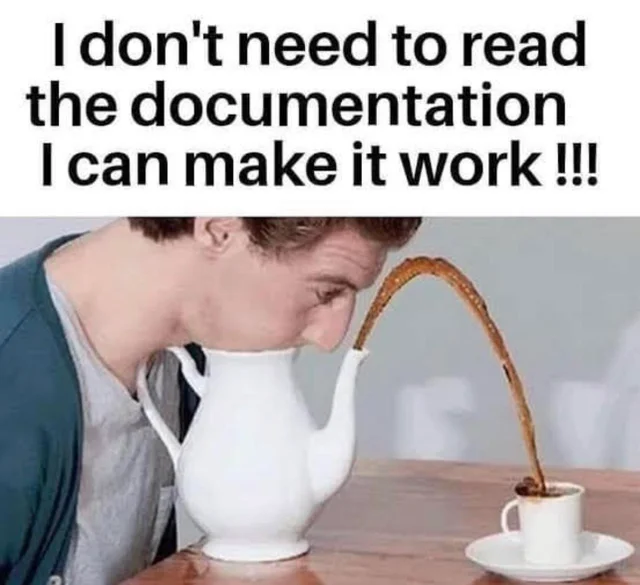

In [9]:
#Mapdisplay: Display ee.Features and ee.Images using folium.

def Mapdisplay(center, dicc, Tiles="OpensTreetMap",zoom_start=10):
    '''
    :param center: Center of the map (Latitude and Longitude).
    :param dicc: Earth Engine Geometries or Tiles dictionary
    :param Tiles: Mapbox Bright,Mapbox Control Room,Stamen Terrain,Stamen Toner,stamenwatercolor,cartodbpositron.
    :zoom_start: Initial zoom level for the map.
    :return: A folium.Map object.
    '''
    mapViz = folium.Map(location=center,tiles=Tiles, zoom_start=zoom_start)
    for k,v in dicc.items():
      if ee.image.Image in [type(x) for x in v.values()]:
        folium.TileLayer(
            tiles = EE_TILES.format(**v),
            attr  = 'Google Earth Engine',
            overlay =True,
            name  = k
          ).add_to(mapViz)
      else:
        folium.GeoJson(
        data = v,
        name = k
          ).add_to(mapViz)
    mapViz.add_child(folium.LayerControl())
    return mapViz

In [11]:
# Installs geemap package
import subprocess

try:
    import geemap
except ImportError:
    print('Installing geemap ...')
    subprocess.check_call(["python", '-m', 'pip', 'install', 'geemap'])

Helpful documentation about gee plotting is available at https://geemap.org/usage/


In [12]:
# Vizualize the treatment and control points
Map = geemap.Map(center=[9.8, 2.4], zoom = 7)
Map.addLayer(treated_village, {'color':'006633'}, "Treated Villages")
Map.addLayer(control_village, {'color':'003366'}, "Control Villages")
Map.addLayer(control_village_points, {}, "Control sampled points")
Map

Map(center=[9.8, 2.4], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(T…


### Raster creation
Create a raster defined over all of Benin with a band defined as 1 in the treated villages, and 0 elsewhere

In [13]:
def maskS2clouds(img):
  '''  
  Function to mask clouds based on the pixel_qa band of Landsat 5 data. See:
  https://developers.google.com/earth-engine/datasets/catalog/LANDSAT_LT05_C01_T1_SR
  
  Params:
  -------
  - img: image input Landsat 5 SR image
  
  Return:
  -------
  cloudmasked Landsat 5 image
  '''
  qa = img.select('pixel_qa')
  cloud = qa.bitwiseAnd(1 << 5)\
            .And(qa.bitwiseAnd(1 << 7))\
            .Or(qa.bitwiseAnd(1 << 3))
  mask2 = img.mask().reduce(ee.Reducer.min())
  return img.updateMask(cloud.Not()).updateMask(mask2)

In [14]:
# Create a raster from the treated village vector
treated_village_rast = treated_village.filter(ee.Filter.notNull(['ORIG_FID'])).reduceToImage(properties=['ORIG_FID'],reducer= ee.Reducer.first())

# Create a village mask based on the treated village raster
villagemask = treated_village_rast.mask() #select(['ORIG_FID']).gt(.1)

# Use landsat 7 from any pre-2009 year (this is when the lottery happened)

# 4.4.3 Prepare the satellite image (Landsat-7) for pre 2009

RGB_bands = ['B3','B2','B1'] #RGB
NDVI_bands = ['B4','B3'] #NIR

benin = ee.FeatureCollection("USDOS/LSIB_SIMPLE/2017").filter(ee.Filter.eq('country_na','Benin')).set('ORIG_FID',0)

# Use Landsat 7 surface reflectance data.
l7 = ee.ImageCollection("LANDSAT/LE07/C01/T1_SR")\
               .filterBounds(db_villages)\
               .filterDate('2005-01-01', '2006-12-31')\
               .filter(ee.Filter.lt('CLOUD_COVER', 20))\
               .map(maskS2clouds)\
               .median()\
                .multiply(.0001)\
                .clip(benin.geometry().buffer(3000))
                              

               #.multiply(0.0001)

print(type(l7))
# print(l7)
l7_ndvi = l7.normalizedDifference(NDVI_bands).rename(['NDVI'])
l7_rgb = l7.select(RGB_bands).rename(['R','G','B']) 

l7 = l7_rgb.addBands(l7_ndvi)

l7Masked = l7.updateMask(villagemask)
l7Unmasked = l7Masked.unmask(-9999)

outside_circle = 'b("R") > -9000'
target = l7Unmasked.expression(outside_circle).rename("target")

l7 = l7.addBands(target)

<class 'ee.image.Image'>


In [15]:
Map2 = geemap.Map(center=[9.8, 2.4], zoom = 7)
Map2.addLayer(target, {}, 'target')
Map2

Map(center=[9.8, 2.4], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(T…

In [55]:
js_snippet = """

// get one image
var image = ee.ImageCollection("LANDSAT/LC08/C01/T1_RT").first();
// calculate the min and max value of an image
var minMax = image.reduceRegion({
  reducer: ee.Reducer.minMax(),
  geometry: image.geometry(),
  scale: 30,
  maxPixels: 10e9,
  // tileScale: 16
}); 
// use unit scale to normalize the pixel values
var unitScale = ee.ImageCollection.fromImages(
  image.bandNames().map(function(name){
    name = ee.String(name);
    var band = image.select(name);
    return band.unitScale(ee.Number(minMax.get(name.cat('_min'))), ee.Number(minMax.get(name.cat('_max'))))
                // eventually multiply by 100 to get range 0-100
                //.multiply(100);
})).toBands().rename(image.bandNames());

// add the the map
Map.addLayer(image, {min: 0, max: 35000, bands: ['B4', 'B3', 'B2']}, 'original')
Map.addLayer(unitScale, {min: 0, max: 1, bands: ['B4', 'B3', 'B2']}, 'unitscaled')
Map.centerObject(unitScale)


"""

In [56]:
geemap.js_snippet_to_py(js_snippet, add_new_cell = True, import_ee = True, import_geemap = True, show_map = True)

In [53]:
# normalize the RGB values to 0 - 1 numbers

#l7.getInfo()
features = ['R', 'G', 'B', 'NDVI']
minMax = l7.reduceRegion(
            reducer = ee.Reducer.minMax(),
            geometry = l7.geometry(),
            scale = 30,
            maxPixels = 10e9)

def unit_scaler(name):
  name = ee.String(name)
  band = l7.select(name)
  return band.unitScale(ee.Number(minMax.get(name.cat('_min'))))
 

unitScale = ee.ImageCollection.fromImages(
    l7.bandNames().map(unit_scaler)
).toBands().rename(l7.bandNames)

#normalized = l7.select(features).unitScale(minMax)

AttributeError: ignored

# Prepare data for export into TFrecord



*   Sample fixed dimension (256x256 pixels) patches centered around each sampled train/test point
*   Export image patches to google cloud storage



In [16]:
import numpy as np
import time

def saveCNN_batch(image, point,kernel_size,scale,FilePrefix, selectors,folder, bucket='cx_bucket_1'):
  """
    Export a dataset for semantic segmentation by batches
  
  Params:
  ------
    - image : ee.Image to get pixels from; must be scalar-valued.
    - point : Points to sample over.
    - kernel_size : The kernel specifying the shape of the neighborhood. Only fixed, square and rectangle kernels are supported.
      Weights are ignored; only the shape of the kernel is used.
    - scale : A nominal scale in meters of the projection to work in.
    - FilePrefix : Cloud Storage object name prefix for the export.
    - selector : Specified the properties to save.
    - bucket : The name of a Cloud Storage bucket for the export.  
  """
  print('Found Cloud Storage bucket.' if tf.io.gfile.exists('gs://' + bucket) 
    else 'Output Cloud Storage bucket does not exist.')
  
  # Download the points (Server -> Client)
  nbands = len(selectors)
  points = train_set.geometry().getInfo()['coordinates']    
  nfeatures = kernel_size*kernel_size*nbands*len(points) #estimate the totals # of features
     
  image_neighborhood = image.neighborhoodToArray(ee.Kernel.rectangle(kernel_size, kernel_size, 'pixels'))
  filenames = []
  
  #Threshold considering the max number of features permitted to export.
  if nfeatures > 3e6:
    nparts = int(np.ceil(nfeatures/3e6))
    print('Dataset too long, splitting it into '+ str(nparts),'equal parts.')
    
    nppoints = np.array(points)
    np.random.shuffle(nppoints)
    
    count_batch = 1  # Batch counter 
    
    for batch_arr in np.array_split(nppoints,nparts):
      
      fcp = ee.FeatureCollection([
          ee.Feature(ee.Geometry.Point(p),{'class':'NA'}) 
          for p in batch_arr.tolist() 
      ])
      
      # Agriculture dataset (fcp-points) collocation to each L5 grid cell value.
      train_db = image_neighborhood.sampleRegions(collection=fcp, scale=scale)
      filename = '%s/%s-%04d_' % (folder,FilePrefix,count_batch)
      
      # Create the tasks for passing of GEE to Google storage
      print('sending the task #%04d'%count_batch)
      Task = ee.batch.Export.table.toCloudStorage(
        collection=train_db,        
        selectors=selectors,          
        description='Export batch '+str(count_batch),
        fileNamePrefix=filename,
        bucket=bucket,  
        fileFormat='TFRecord')
      
      Task.start()
      filenames.append(filename)
      count_batch+=1
      
      while Task.active():
        print('Polling for task (id: {}).'.format(Task.id))
        time.sleep(3)
        
    return filenames
  
  else:    
    train_db = image_neighborhood.sampleRegions(collection=points, scale=scale)         
    Task = ee.batch.Export.table.toCloudStorage(
      collection=train_db,
      selectors=selectors,
      description='Training Export',
      fileNamePrefix=FilePrefix,
      bucket=bucket,  
      fileFormat='TFRecord')
    Task.start()
    
    while Task.active():
      print('Polling for task (id: {}).'.format(Task.id))
      time.sleep(3)
    
    return FilePrefix

In [ ]:
selectors = ['R','G','B','NDVI','target']
train_filenames = saveCNN_batch(l7,train_set,128,30,'trainUNET', selectors,folder ='unet')
test_filenames = saveCNN_batch(l7,test_set,128,30,'testUNET', selectors,folder ='unet')

Found Cloud Storage bucket.
Dataset too long, splitting it into 16 equal parts.
sending the task #0001
Polling for task (id: TAV3RE6CS2VBEL57COKHOOXB).
Polling for task (id: TAV3RE6CS2VBEL57COKHOOXB).
Polling for task (id: TAV3RE6CS2VBEL57COKHOOXB).
Polling for task (id: TAV3RE6CS2VBEL57COKHOOXB).
Polling for task (id: TAV3RE6CS2VBEL57COKHOOXB).
Polling for task (id: TAV3RE6CS2VBEL57COKHOOXB).
Polling for task (id: TAV3RE6CS2VBEL57COKHOOXB).
Polling for task (id: TAV3RE6CS2VBEL57COKHOOXB).
Polling for task (id: TAV3RE6CS2VBEL57COKHOOXB).
Polling for task (id: TAV3RE6CS2VBEL57COKHOOXB).
Polling for task (id: TAV3RE6CS2VBEL57COKHOOXB).
Polling for task (id: TAV3RE6CS2VBEL57COKHOOXB).
Polling for task (id: TAV3RE6CS2VBEL57COKHOOXB).
Polling for task (id: TAV3RE6CS2VBEL57COKHOOXB).
Polling for task (id: TAV3RE6CS2VBEL57COKHOOXB).
Polling for task (id: TAV3RE6CS2VBEL57COKHOOXB).
Polling for task (id: TAV3RE6CS2VBEL57COKHOOXB).
Polling for task (id: TAV3RE6CS2VBEL57COKHOOXB).
Polling for tas

In [ ]:
# Fullname train/test db
folder = 'unet'
bucket = 'cx_bucket_1'

filesList = !gsutil ls 'gs://'{bucket}'/'{folder}

trainFilePrefix = 'trainUNET'
trainFilePath = [s for s in filesList if trainFilePrefix in s]


testFilePrefix = 'testUNET'
testFilePath = [s for s in filesList if testFilePrefix in s]

In [ ]:
def input_fn(fileNames, numEpochs=None, shuffle=True, batchSize=16, side = 257):
  # Read `TFRecordDatasets` 
  dataset = tf.data.TFRecordDataset(fileNames, compression_type='GZIP')

  # Names of the features 
  feature_columns = {
    'R': tf.io.FixedLenFeature([side, side], dtype=tf.float32),  
    'G': tf.io.FixedLenFeature([side, side], dtype=tf.float32),  
    'B': tf.io.FixedLenFeature([side, side], dtype=tf.float32),    
    'NDVI': tf.io.FixedLenFeature([side, side], dtype=tf.float32),    
    'target': tf.io.FixedLenFeature([side, side], dtype=tf.float32)
  }
  
  # Make a parsing function
  def parse(example_proto):
    parsed_features = tf.io.parse_single_example(example_proto, feature_columns)   
    # passing of 257x257 to 256x256
    parsed_features = {key:value[1:side,1:side] for key,value in parsed_features.items()} 
    # Separate the class labels from the training features
    labels = parsed_features.pop('target')
    return parsed_features, tf.cast(labels, tf.float32)
  
  # Passing of FeatureColumns to a 4D tensor
  def stack_images(features,label):         
    nfeat = tf.transpose(tf.squeeze(tf.stack(list(features.values()))))
    nlabel = (tf.transpose(label))[:,:,tf.newaxis]
    return nfeat, nlabel
  
  dataset = dataset.map(parse, num_parallel_calls=4)
  dataset = dataset.map(stack_images, num_parallel_calls=4)
  
  if shuffle:
    dataset = dataset.shuffle(buffer_size = batchSize * 10)
  dataset = dataset.batch(batchSize)
  dataset = dataset.repeat(numEpochs)
  
  return dataset

In [ ]:
train_dba = input_fn(trainFilePath,100,True,3)
test_dba = input_fn(testFilePath, numEpochs=1, batchSize=1, shuffle=False)

TODO: calculate quantiles for each band, and then standardize to 0-1. Take representative and then apply to entire. min-max scaling, but on 95th percentile as ceiling

ValueError: ignored

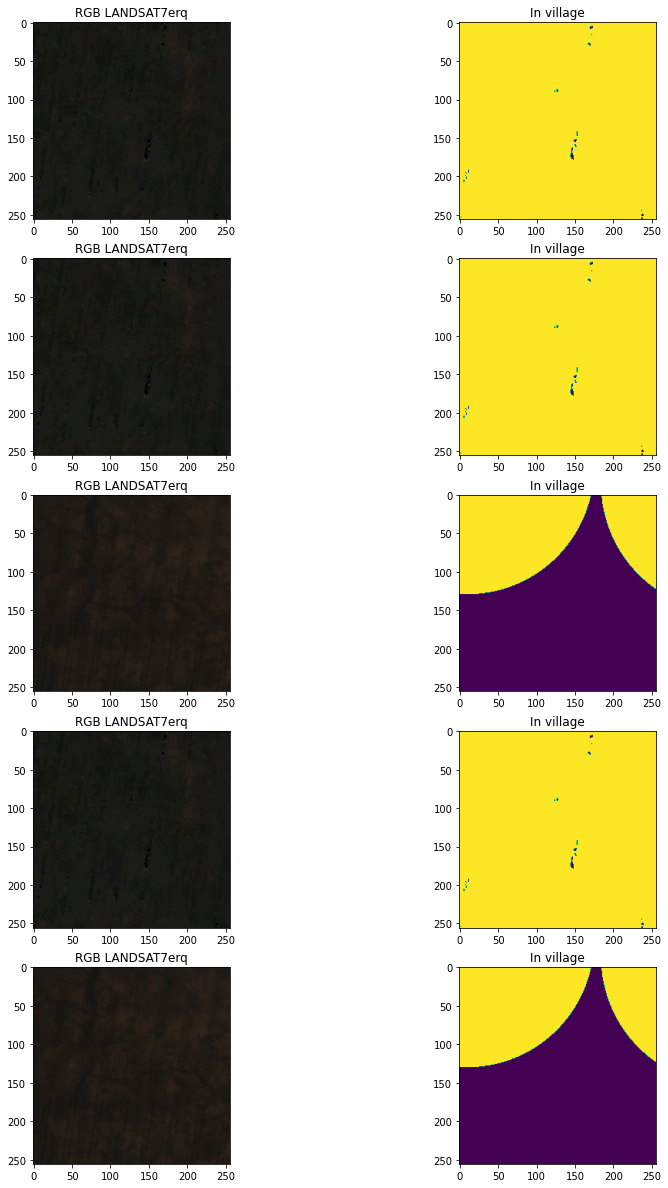

In [ ]:
## Vizualize a few patches in the train and test sets

import matplotlib.pyplot as plt
import numpy as np

display_num = 5
plt.figure(figsize=(14, 21))

c=0
for i in range(1, display_num):
  for x in test_dba.take(i):
    tensor = tf.squeeze(x[0]).numpy()[:,:,[3,1,0]]
    target = tf.squeeze(x[1])

    #print(target.sum())  
    plt.subplot(display_num, 2, c + 1)
    plt.imshow(tensor)
    plt.title("RGB LANDSAT7erq")
    
    plt.subplot(display_num, 2, c + 2)
    plt.imshow(target)
    plt.title("In village")
    c+=2 
plt.show()

# Model Definition

UNet implementation with training parameters. Is it better to do transfer learning here on a pre-trained model? 

In [ ]:
IMG_SHAPE  = (256, 256, 4)
EPOCHS = 10

In [ ]:
from tensorflow.keras import layers

def conv_block(input_tensor, num_filters):
  encoder = layers.Conv2D(num_filters, (3, 3), padding='same')(input_tensor)
  encoder = layers.BatchNormalization()(encoder)
  encoder = layers.Activation('relu')(encoder)
  encoder = layers.Conv2D(num_filters, (3, 3), padding='same')(encoder)
  encoder = layers.BatchNormalization()(encoder)
  encoder = layers.Activation('relu')(encoder)
  return encoder

def encoder_block(input_tensor, num_filters):
  encoder = conv_block(input_tensor, num_filters)
  encoder_pool = layers.MaxPooling2D((2, 2), strides=(2, 2))(encoder)
  
  return encoder_pool, encoder

def decoder_block(input_tensor, concat_tensor, num_filters):
  decoder = layers.Conv2DTranspose(num_filters, (2, 2), strides=(2, 2), padding='same')(input_tensor)
  decoder = layers.concatenate([concat_tensor, decoder], axis=-1)
  decoder = layers.BatchNormalization()(decoder)
  decoder = layers.Activation('relu')(decoder)
  decoder = layers.Conv2D(num_filters, (3, 3), padding='same')(decoder)
  decoder = layers.BatchNormalization()(decoder)
  decoder = layers.Activation('relu')(decoder)
  decoder = layers.Conv2D(num_filters, (3, 3), padding='same')(decoder)
  decoder = layers.BatchNormalization()(decoder)
  decoder = layers.Activation('relu')(decoder)
  return decoder

inputs = layers.Input(shape=IMG_SHAPE)
# 256
encoder0_pool, encoder0 = encoder_block(inputs, 32)
# 128
encoder1_pool, encoder1 = encoder_block(encoder0_pool, 64)
# 64
encoder2_pool, encoder2 = encoder_block(encoder1_pool, 128)
# 32
encoder3_pool, encoder3 = encoder_block(encoder2_pool, 256)
# 16
encoder4_pool, encoder4 = encoder_block(encoder3_pool, 512)
# 8
center = conv_block(encoder4_pool, 1024)
# center
decoder4 = decoder_block(center, encoder4, 512)
# 16
decoder3 = decoder_block(decoder4, encoder3, 256)
# 32
decoder2 = decoder_block(decoder3, encoder2, 128)
# 64
decoder1 = decoder_block(decoder2, encoder1, 64)
# 128
decoder0 = decoder_block(decoder1, encoder0, 32)
# 256

outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(decoder0)

In [ ]:
from tensorflow.keras import models
model = models.Model(inputs=[inputs], outputs=[outputs])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 4  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 32  1184        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                             

In [ ]:
from tensorflow.keras import losses

def dice_coeff(y_true, y_pred):
    smooth = 1.
    # Flatten
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)
    return score

def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss

def bce_dice_loss(y_true, y_pred):
  loss = losses.binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
  return loss

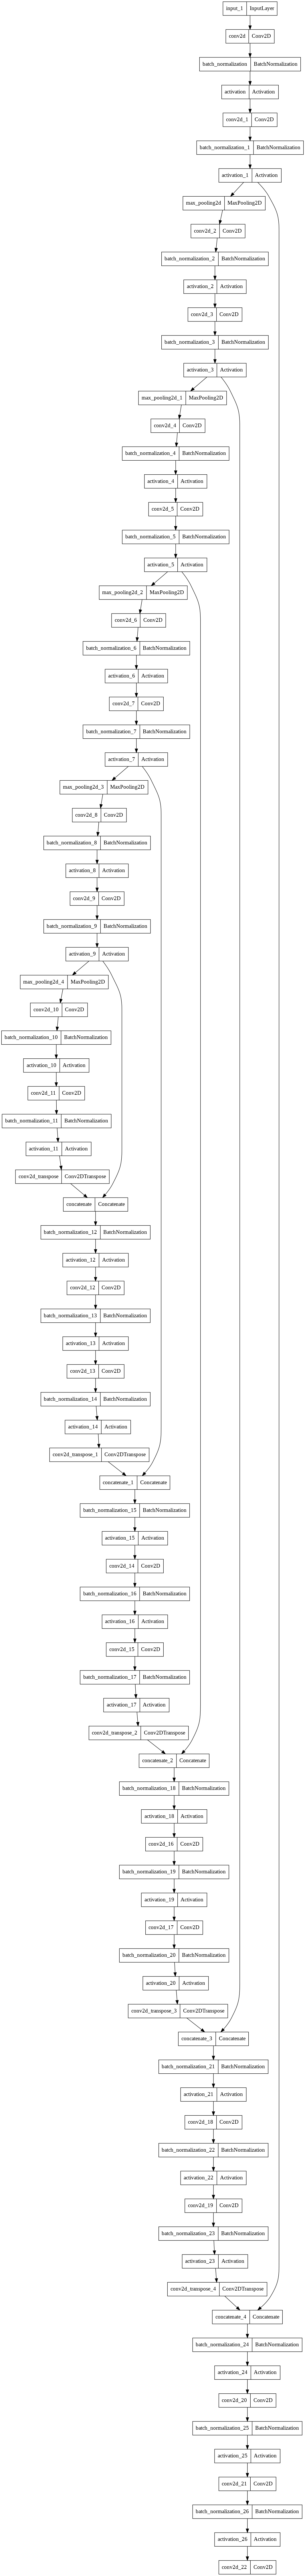

In [ ]:
from tensorflow.keras.utils import plot_model
model.compile(optimizer='adam', loss=bce_dice_loss, metrics=[dice_loss])
plot_model(model)

In [ ]:
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import os
import datetime

# Callbacks time
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
es = EarlyStopping(monitor='val_loss', patience=10)
mcp = ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)

In [ ]:
# Run this cell to mount your Google Drive.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Model training and evaluation


In [ ]:
data= test_dba.take(1)
type(data)

tensorflow.python.data.ops.dataset_ops.TakeDataset

In [ ]:
data_tensor.shape

(256, 256, 3)

In [ ]:
data_target.shape

TensorShape([256, 256])

In [ ]:
type(test_dba)

tensorflow.python.data.ops.dataset_ops.RepeatDataset

In [ ]:
N_train = 550
batch_size = 3

# Train the model I just do it for 15 minutes
history = model.fit(train_dba,
                    steps_per_epoch= int(np.ceil(N_train / float(batch_size))),
                    epochs=EPOCHS,
                    validation_data=test_dba)


#callbacks=[tensorboard_callback,es,mcp]

Epoch 1/10
184/184 [==============================] - 932s 5s/step - loss: 0.9276 - dice_loss: 0.3096 - val_loss: 1.6084 - val_dice_loss: 0.3013
Epoch 2/10
184/184 [==============================] - 932s 5s/step - loss: 0.8902 - dice_loss: 0.2873 - val_loss: 0.9413 - val_dice_loss: 0.3566
Epoch 3/10
184/184 [==============================] - 932s 5s/step - loss: 0.8870 - dice_loss: 0.2859 - val_loss: 0.9206 - val_dice_loss: 0.3536
Epoch 4/10
184/184 [==============================] - 930s 5s/step - loss: 0.8813 - dice_loss: 0.2829 - val_loss: 0.9032 - val_dice_loss: 0.3404
Epoch 5/10
184/184 [==============================] - 923s 5s/step - loss: 0.8670 - dice_loss: 0.2768 - val_loss: 0.9183 - val_dice_loss: 0.3452
Epoch 6/10
184/184 [==============================] - 921s 5s/step - loss: 0.8670 - dice_loss: 0.2759 - val_loss: 0.9829 - val_dice_loss: 0.2897
Epoch 7/10
184/184 [==============================] - 972s 5s/step - loss: 0.8630 - dice_loss: 0.2758 - val_loss: 0.9049 - val_dic

In [ ]:
!mkdir -p drive/MyDrive/unet
model.save('drive/MyDrive/unet/unet4_18')

INFO:tensorflow:Assets written to: drive/MyDrive/unet/unet4_18/assets


In [ ]:
loss, acc = model.evaluate(test_dba)

534/534 [==============================] - 207s 387ms/step - loss: 0.9969 - dice_loss: 0.3705


In [ ]:
acc

0.3704955279827118

In [ ]:
loss

0.996862530708313

In [ ]:
history.params

{'epochs': 10, 'steps': 184, 'verbose': 1}

dict_keys(['loss', 'dice_loss', 'val_loss', 'val_dice_loss'])


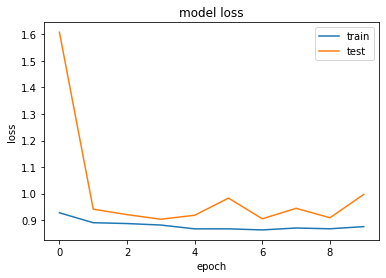

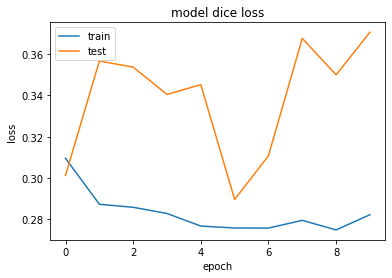

In [ ]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()
# summarize history for loss
plt.plot(history.history['dice_loss'])
plt.plot(history.history['val_dice_loss'])
plt.title('model dice loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# Plot P(treatment) vs density

# 3 fold cross validation

# Use median composite image before 2009. 

# Generate harmonic coefficients and add as a potential data channel



# Loading and using pre-trained model

In [ ]:
model = tf.saved_model.load('drive/MyDrive/unet/unet4_18')

In [ ]:
dat = test_dba.take(1)

for data,labels in dat:
  data_1 = data
  labels_1 = data

print(data_1.shape)

(1, 256, 256, 4)


Generate predictions on l7 imagery

In [ ]:
# Use Landsat 7 surface reflectance data.
l7 = ee.ImageCollection("LANDSAT/LE07/C01/T1_SR")\
               .filterBounds(db_villages)\
               .filterDate('2005-01-01', '2006-12-31')\
               .filter(ee.Filter.lt('CLOUD_COVER', 20))\
               .map(maskS2clouds)\
               .median()\
                .multiply(.0001)\
                .clip(benin.geometry().buffer(3000))
                              
l7_ndvi = l7.normalizedDifference(NDVI_bands).rename(['NDVI'])
l7_rgb = l7.select(RGB_bands).rename(['R','G','B'])
l7 = l7_rgb.addBands(l7_ndvi)

In [ ]:
Map_eval = geemap.Map(center=[9.8, 2.4], zoom = 7)
Map_eval.addLayer(l7, vis_params = {'bands':['R','G','B'], 'min':0, 'max':0.5,'gamma':1.4},name = 'l7 imagery')
Map_eval

Map(center=[9.8, 2.4], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(T…

In [ ]:
outputBucket = 'cx_bucket_1'
imageFilePrefix = 'unet/Predict_InBeninVillage'

# Specify patch and file dimensions.
imageExportFormatOptions = {
  'patchDimensions': [256, 256],
  'compressed': True
}

# Setup the task.
imageTask = ee.batch.Export.image.toCloudStorage(
  image=l7,
  description='Image Export',
  fileNamePrefix=imageFilePrefix,
  bucket=outputBucket,
  scale=30,
  fileFormat='TFRecord',
  region=benin.geometry().buffer(2500).getInfo()['coordinates'],
  formatOptions=imageExportFormatOptions,
)

imageTask.start()

In [ ]:
import time 
while imageTask.active():
  print('Polling for task (id: {}).'.format(imageTask.id))
  time.sleep(5)

Polling for task (id: AHTIUCBSFXPMYMOQ3M4CA4V6).
Polling for task (id: AHTIUCBSFXPMYMOQ3M4CA4V6).
Polling for task (id: AHTIUCBSFXPMYMOQ3M4CA4V6).
Polling for task (id: AHTIUCBSFXPMYMOQ3M4CA4V6).
Polling for task (id: AHTIUCBSFXPMYMOQ3M4CA4V6).
Polling for task (id: AHTIUCBSFXPMYMOQ3M4CA4V6).
Polling for task (id: AHTIUCBSFXPMYMOQ3M4CA4V6).
Polling for task (id: AHTIUCBSFXPMYMOQ3M4CA4V6).
Polling for task (id: AHTIUCBSFXPMYMOQ3M4CA4V6).
Polling for task (id: AHTIUCBSFXPMYMOQ3M4CA4V6).
Polling for task (id: AHTIUCBSFXPMYMOQ3M4CA4V6).
Polling for task (id: AHTIUCBSFXPMYMOQ3M4CA4V6).
Polling for task (id: AHTIUCBSFXPMYMOQ3M4CA4V6).
Polling for task (id: AHTIUCBSFXPMYMOQ3M4CA4V6).
Polling for task (id: AHTIUCBSFXPMYMOQ3M4CA4V6).
Polling for task (id: AHTIUCBSFXPMYMOQ3M4CA4V6).
Polling for task (id: AHTIUCBSFXPMYMOQ3M4CA4V6).


Begin to classify images using tensorflow

In [ ]:
filesList = !gsutil ls 'gs://'{outputBucket}'/unet/'
exportFilesList = [s for s in filesList if imageFilePrefix in s]

# Get the list of image files and the JSON mixer file.
imageFilesList = []
jsonFile = None
for f in exportFilesList:
  if f.endswith('.tfrecord.gz'):
    imageFilesList.append(f)
  elif f.endswith('.json'):
    jsonFile = f

# Make sure the files are in the right order.
print(jsonFile)

None


In [ ]:
import json
from pprint import pprint 

# Load the contents of the mixer file to a JSON object.
jsonText = !gsutil cat {jsonFile}
# Get a single string w/ newlines from the IPython.utils.text.SList
mixer = json.loads(jsonText.nlstr)
pprint(mixer)

JSONDecodeError: ignored

In [ ]:
## Vizualize a few patches in the train and test sets

import matplotlib.pyplot as plt
import numpy as np

display_num = 5
plt.figure(figsize=(14, 21))

c=0
for i in range(1, display_num):
  for x in test_dba.take(i):
    tensor = tf.squeeze(x[0]).numpy()[:,:,[3,1,0]]
    target = tf.squeeze(x[1])
    tensor = tensor.reshape((256, 256, 4))
    pred = model(tensor)
    pred = tf.squeeze(pred)

    #print(target.sum())  
    plt.subplot(display_num, 2, c + 1)
    plt.imshow(pred)
    plt.title("RGB LANDSAT7erq")
    
    plt.subplot(display_num, 2, c + 2)
    plt.imshow(target)
    plt.title("In village")
    c+=2 
plt.show()

ValueError: ignored

<Figure size 1008x1512 with 0 Axes>

In [ ]:
1008 * 1512 - (256 * 256 * 3)

1327488

In [ ]:
rounded_pred_data = round(pred_data_1)

TODO:
Earth engine has way to load tensorflow model. Google cloud AI, try and export it into a model here

histograms of probability of treatment from pre-treatment imagery. separate into classes of treated v untreated

For now, stick to just median composite -- seems like something to do in a bit

Generate prediction over all of benin

Everything in Ali

In [ ]:
labels_1[0,:,:,3]

<tf.Tensor: shape=(256, 256), dtype=float32, numpy=
array([[0.0867 , 0.0928 , 0.0936 , ..., 0.09815, 0.09495, 0.09655],
       [0.0867 , 0.0875 , 0.0871 , ..., 0.0997 , 0.0997 , 0.0998 ],
       [0.0845 , 0.0867 , 0.0867 , ..., 0.0965 , 0.0997 , 0.0998 ],
       ...,
       [0.0617 , 0.064  , 0.     , ..., 0.0899 , 0.0928 , 0.1054 ],
       [0.076  , 0.0954 , 0.074  , ..., 0.0899 , 0.0944 , 0.1006 ],
       [0.07445, 0.0928 , 0.0794 , ..., 0.093  , 0.0881 , 0.0975 ]],
      dtype=float32)>

In [ ]:
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

for data,label in test_dba:
  pred = model(data)
  #print(pred.shape)
  print(label.shape)
  #print(data.shape)

(1, 256, 256, 1)
(1, 256, 256, 1)
(1, 256, 256, 1)
(1, 256, 256, 1)
(1, 256, 256, 1)
(1, 256, 256, 1)
(1, 256, 256, 1)
(1, 256, 256, 1)
(1, 256, 256, 1)
(1, 256, 256, 1)
(1, 256, 256, 1)
(1, 256, 256, 1)
(1, 256, 256, 1)
(1, 256, 256, 1)
(1, 256, 256, 1)
(1, 256, 256, 1)
(1, 256, 256, 1)
(1, 256, 256, 1)
(1, 256, 256, 1)
(1, 256, 256, 1)
(1, 256, 256, 1)
(1, 256, 256, 1)
(1, 256, 256, 1)
(1, 256, 256, 1)
(1, 256, 256, 1)
(1, 256, 256, 1)
(1, 256, 256, 1)
(1, 256, 256, 1)
(1, 256, 256, 1)
(1, 256, 256, 1)
(1, 256, 256, 1)
(1, 256, 256, 1)
(1, 256, 256, 1)
(1, 256, 256, 1)
(1, 256, 256, 1)
(1, 256, 256, 1)
(1, 256, 256, 1)
(1, 256, 256, 1)
(1, 256, 256, 1)
(1, 256, 256, 1)
(1, 256, 256, 1)
(1, 256, 256, 1)
(1, 256, 256, 1)
(1, 256, 256, 1)
(1, 256, 256, 1)
(1, 256, 256, 1)
(1, 256, 256, 1)
(1, 256, 256, 1)
(1, 256, 256, 1)
(1, 256, 256, 1)
(1, 256, 256, 1)
(1, 256, 256, 1)
(1, 256, 256, 1)
(1, 256, 256, 1)
(1, 256, 256, 1)
(1, 256, 256, 1)
(1, 256, 256, 1)
(1, 256, 256, 1)
(1, 256, 256, 

KeyboardInterrupt: ignored

# Testing junk


In [ ]:
dummy_train_var = np.array((1,2,3))
tf.cast(dummy_train_var, tf.float32)

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([1., 2., 3.], dtype=float32)>

In [ ]:
# Create a map centered at (lat, lon).
Map = geemap.Map(center=[40, -100], zoom=4)

# Load a collection of US counties.
counties = ee.FeatureCollection('TIGER/2018/Counties')

# Make an image out of the land area attribute.
landAreaImg = counties \
  .filter(ee.Filter.notNull(['ALAND'])) \
  .reduceToImage(**{
    'properties': ['ALAND'],
    'reducer': ee.Reducer.first()
})

# Display the county land area image.
Map.setCenter(-99.976, 40.38, 5)
Map.addLayer(landAreaImg, {
  'min': 3e8,
  'max': 1.5e10,
  'palette': ['FCFDBF', 'FDAE78', 'EE605E', 'B63679', '711F81', '2C105C']
}, 'Land Area')

# Display the map.
Map

Map(center=[40.38, -99.976], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(child…

In [ ]:
img = ee.Image('COPERNICUS/S2_SR/20210109T185751_20210109T185931_T10SEG')
trueColorViz = {
  'bands': ['B4', 'B3', 'B2'],
  'min': 0,
  'max': 2700,
  'gamma': 1.3
}

Map = geemap.Map(center=[40, -100], zoom=4)
Map.setCenter(-122.36, 37.47, 10);
Map.addLayer(img, trueColorViz, 'Sentinel-2 image')

Map

Map(center=[37.47, -122.36], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(child…

Point (-122.1935, 37.2893) at 305m/px
Image, unmasked: Image (23 bands)
  AOT: 63
  B1: 40
  B11: 810
  B12: 343
  B2: 49
  B3: 190
  B4: 117
  B5: 436
  B6: 1463
  B7: 1794
  B8: 1967
  B8A: 2018
  B9: 2270
  MSK_CLDPRB: 0
  MSK_SNWPRB: 0
  QA10: 0
  QA20: 0
  QA60: 0
  SCL: 4
  TCI_B: 7
  TCI_G: 20
  TCI_R: 13
  WVP: 860
Image, unmasked: Image (23 bands)
  AOT: 32767
  B1: 32767
  B11: 32767
  B12: 32767
  B2: 32767
  B3: 32767
  B4: 32767
  B5: 32767
  B6: 32767
  B7: 32767
  B8: 32767
  B8A: 32767
  B9: 32767
  MSK_CLDPRB: 32767
  MSK_SNWPRB: 32767
  QA10: 32767
  QA20: 32767
  QA60: 32767
  SCL: 32767
  TCI_B: 32767
  TCI_G: 32767
  TCI_R: 32767
  WVP: 32767


In [ ]:
landMask = img.select('B11').gt(100)
Map.addLayer(landMask, {'palette': ['blue', 'lightgreen']}, 'Land mask')

In [ ]:
imgMasked = img.updateMask(landMask)
Map.addLayer(imgMasked, trueColorViz, 'Image, land only')

In [ ]:
imgUnmasked = imgMasked.unmask(32767)
Map.addLayer(imgUnmasked, trueColorViz, 'Image, unmasked')

In [ ]:
# 08_masking.ipynb 
Map = geemap.Map(center=[40,-100], zoom=4)
Map

Map(center=[40, -100], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(T…

In [ ]:
# Add Earth Engine dataset
# This function gets NDVI from Landsat 5 imagery.


def getNDVI(image):
    return image.normalizedDifference(['B4', 'B3'])


# Load two Landsat 5 images, 20 years apart.
image1 = ee.Image('LANDSAT/LT05/C01/T1_TOA/LT05_044034_19900604')
image2 = ee.Image('LANDSAT/LT05/C01/T1_TOA/LT05_044034_20100611')

# Compute NDVI from the scenes.
ndvi1 = getNDVI(image1)
ndvi2 = getNDVI(image2)

# Compute the difference in NDVI.
ndviDifference = ndvi2.subtract(ndvi1)
# Load the land mask from the SRTM DEM.
landMask = ee.Image('CGIAR/SRTM90_V4').mask()

# Update the NDVI difference mask with the land mask.
maskedDifference = ndviDifference.updateMask(landMask)

# Display the masked result.
vizParams = {'min': -0.5, 'max': 0.5,
             'palette': ['FF0000', 'FFFFFF', '0000FF']}
Map.setCenter(-122.2531, 37.6295, 9)
Map.addLayer(maskedDifference, vizParams, 'NDVI difference')


In [ ]:
Map.addLayer(landMask, {}, 'land mask')

In [ ]:
Map.addLayerControl() # This line is not needed for ipyleaflet-based Map.
Map

Map(bottom=51029.0, center=[37.6295, -122.2531], controls=(WidgetControl(options=['position', 'transparent_bg'…